In [1]:
import torch

# Confirm that the GPU is detected

assert torch.cuda.is_available()

# Get the GPU device name.
device_name = torch.cuda.get_device_name()
n_gpu = torch.cuda.device_count()
print(f"Found device: {device_name}, n_gpu: {n_gpu}")
device = torch.device("cuda")

Found device: Tesla T4, n_gpu: 1


In [2]:
!pip install transformers
!pip install -U -q PyDrive

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install git+https://github.com/adapter-hub/adapter-transformers.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/adapter-hub/adapter-transformers.git to /tmp/pip-req-build-q1o5pa55
  Running command git clone --filter=blob:none --quiet https://github.com/adapter-hub/adapter-transformers.git /tmp/pip-req-build-q1o5pa55
  Resolved https://github.com/adapter-hub/adapter-transformers.git to commit b7c9c38888f7707d206860eb1c0f7366a1776ed0
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [4]:
import pandas as pd
from transformers import XLMRobertaForSequenceClassification, AdamW, XLMRobertaConfig
from torch.utils.data import TensorDataset, random_split
from transformers import AutoTokenizer
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
import sys
import numpy as np
import time
import datetime

def tokenize_and_format(sentences):
  tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base", do_lower_case=False)

  # Tokenize all of the sentences and map the tokens to thier word IDs.
  input_ids = []
  attention_masks = []

  # For every sentence...
  for sentence in sentences:
      # `encode_plus` will:
      #   (1) Tokenize the sentence.
      #   (2) Prepend the `[CLS]` token to the start.
      #   (3) Append the `[SEP]` token to the end.
      #   (4) Map tokens to their IDs.
      #   (5) Pad or truncate the sentence to `max_length`
      #   (6) Create attention masks for [PAD] tokens.
      encoded_dict = tokenizer.encode_plus(
                          sentence,                      # Sentence to encode.
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                          max_length = 64,           # Pad & truncate all sentences.
                          padding = 'max_length',
                          truncation = True,
                          return_attention_mask = True,   # Construct attn. masks.
                          return_tensors = 'pt',     # Return pytorch tensors.
                    )

      # Add the encoded sentence to the list.
      input_ids.append(encoded_dict['input_ids'])

      # And its attention mask (simply differentiates padding from non-padding).
      attention_masks.append(encoded_dict['attention_mask'])
  return input_ids, attention_masks

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


The cell below imports some helper functions we wrote to demonstrate the task on the sample tweet dataset.

In [5]:
import pandas as pd

data = pd.read_csv("/content/NLP Ethos - ethos.csv")
data = data.sample(frac = 1).reset_index(drop=True)
total = data.shape[0]
train_data = data.iloc[:801, 2:]
validation_data_eng = data.iloc[801:944, 2:]
validation_data_hindi = data.iloc[944:, 2:]
train_data.head()

,Label,Translation
0,1,लगभग सभी असभ्य संस्कृतियों और मरुस्थल धर्मों क...
1,1,ट्रांसजेंडर बहुत ही घृणित हैं
2,0,"ट्रम्प एक झूठा और एक बेवकूफ, एक डौश बैग, नार्स..."
3,0,मैं सुबह 4 बजे शुरू होने वाली 10 घंटे की ड्यूट...
4,1,I wish HIV to your butthole male whore


In [6]:
validation_data_eng.head()

,Label,Translation
801,1,gays suckï»¿
802,1,he should have put some nigger brains on the p...
803,1,Are you mentally handicapped or this is your n...
804,0,मुझे लगता है कि रिपोर्टर को एक पिस्तौल या कुछ ...
805,1,अगर पुरुषों को महिलाओं को नहीं मारना चाहिए क्य...


In [7]:
validation_data_hindi.head()

,Label,Translation
944,1,इस सीधे आदमी को अपमानित करना। सीधे लोग उसे पसं...
945,1,"पुरुष सुंदरता देख सकते हैं, इसलिए वे अश्वेत मह..."
946,1,कोई बलपूर्वक परिवर्तित कैसे किया जा सकता है? य...
947,1,This is just crazy liberal satanic crap. Don't...
948,0,It's killing me seeing gays treated like that


In [8]:
print('Shape of training data is:', train_data.shape)
print('Shape of validation data (eng) is:', validation_data_eng.shape)
print('Shape of validation data (hindi) is:', validation_data_hindi.shape)

train_len = train_data.shape[0]
val_len_eng = validation_data_eng.shape[0]
val_len_hindi = validation_data_hindi.shape[0]

Shape of training data is: (801, 2)
Shape of validation data (eng) is: (143, 2)
Shape of validation data (hindi) is: (78, 2)


<Axes: xlabel='Label', ylabel='count'>

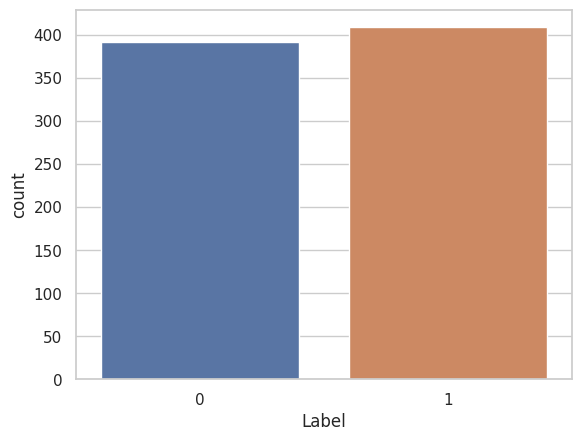

In [9]:
import seaborn as sns
sns.set_theme(style="whitegrid")
sns.countplot(x=train_data['Label'])

<Axes: xlabel='Label', ylabel='count'>

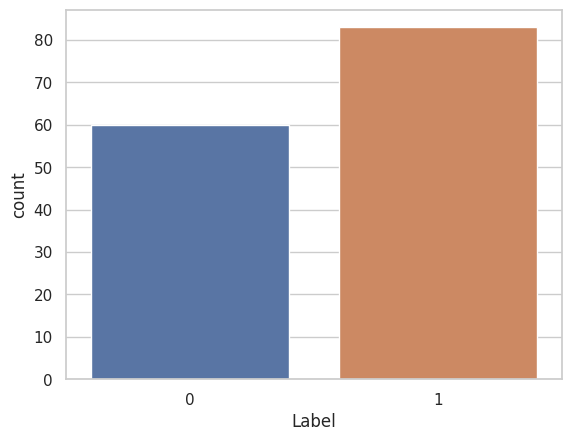

In [10]:
sns.set_theme(style="whitegrid")
sns.countplot(x=validation_data_eng['Label'])

<Axes: xlabel='Label', ylabel='count'>

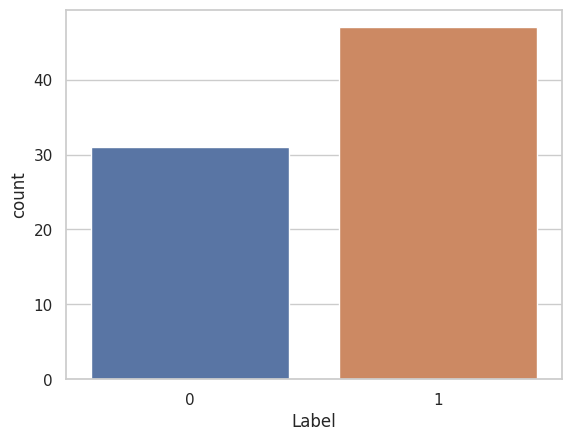

In [11]:
sns.set_theme(style="whitegrid")
sns.countplot(x=validation_data_hindi['Label'])

In [12]:
text = data.Translation.values
labels = data.Label.values

### tokenize_and_format() is a helper function provided in helpers.py ###
input_ids, attention_masks = tokenize_and_format(text)

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', text[0])
print('Token IDs:', input_ids[0])

Original:  लगभग सभी असभ्य संस्कृतियों और मरुस्थल धर्मों के लोग एक जैसे होते हैं।
Token IDs: tensor([     0,  96671,  17415,  20571,  53778, 130002,   7549,    871,   3396,
         16727, 118640,  15858,   1302,    287,  19181,    967,  38380,   8358,
          1293,    125,      2,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1])


In [13]:
train_data = data.iloc[:801, 2:]
validation_data_eng = data.iloc[801:944, 2:]
validation_data_hindi = data.iloc[944:, 2:]

# make lists of 3-tuples (already shuffled the dataframe in cell above)

train_set = [(input_ids[i], attention_masks[i], labels[i]) for i in range(801)]
val_set_eng = [(input_ids[i], attention_masks[i], labels[i]) for i in range(801, 944)]
val_set_hindi = [(input_ids[i], attention_masks[i], labels[i]) for i in range(944, total)]


train_text = [text[i] for i in range(801)]
val_text_eng = [text[i] for i in range(801, 944)]
val_text_hindi = [text[i] for i in range(944, total)]

In [14]:
data_eng = pd.read_csv("/content/final dataset - eng - Sheet1.csv")
data_eng = data_eng.sample(frac = 1).reset_index(drop=True)
test_data_eng = data_eng.iloc[:, 1:]
test_data_eng.head()

,label,Translations
0,1,You’re right. This is beneath me. Like your mo...
1,0,The only reason I came tonight was to get my p...
2,1,"But instead of vampires, we had meth heads. Bu..."
3,1,"Well, dead whore on TV, live one in real life"
4,1,There are a lot of bitches out there


In [15]:
data_hindi = pd.read_csv("/content/final_dataset - hindi - Sheet1.csv")
data_hindi = data_hindi.sample(frac = 1).reset_index(drop=True)
test_data_hindi = data_hindi.iloc[:, 1:]
test_data_hindi.head()

,label,Translations
0,0,मैं अपने माता-पिता को अब अपने भविष्य को नियंत्...
1,1,"मम्मी, पैपा, मैं आपको मेरी नई दिलचस्पी, पेनी स..."
2,1,तुम मेरी एंटुराज के एक अमूल्य अंग साबित हो रहे...
3,1,"नहीं, अब R. केली से कुछ गाने बजाने का और चुम्ब..."
4,1,क्या आप चाहेंगे कि मैं आपको एक और कारण बताऊं क...


In [16]:
test_text_eng = test_data_eng.Translations.values
test_labels_eng = test_data_eng.label.values
test_len_eng = test_data_eng.shape[0]

### tokenize_and_format() is a helper function provided in helpers.py ###
test_input_ids_eng, test_attention_masks_eng = tokenize_and_format(test_text_eng)

# Convert the lists into tensors.
test_input_ids_eng = torch.cat(test_input_ids_eng, dim=0)
test_attention_masks_eng = torch.cat(test_attention_masks_eng, dim=0)
test_labels_eng = torch.tensor(test_labels_eng)

# Print sentence 0, now as a list of IDs.
print('Original: ', test_text_eng[0])
print('Token IDs:', test_input_ids_eng[0])

test_set_eng = [(test_input_ids_eng[i], test_attention_masks_eng[i], test_labels_eng[i]) for i in range(test_len_eng)]

Original:  You’re right. This is beneath me. Like your mother was last night
Token IDs: tensor([    0,  2583,    26,   107,  7108,     5,  3293,    83,  9149, 10519,
          163,     5, 18852,   935, 42732,   509,  4568, 17431,     2,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1])


In [17]:
test_text_hindi = test_data_hindi.Translations.values
test_labels_hindi = test_data_hindi.label.values
test_len_hindi = test_data_hindi.shape[0]

### tokenize_and_format() is a helper function provided in helpers.py ###
test_input_ids_hindi, test_attention_masks_hindi = tokenize_and_format(test_text_hindi)

# Convert the lists into tensors.
test_input_ids_hindi = torch.cat(test_input_ids_hindi, dim=0)
test_attention_masks_hindi = torch.cat(test_attention_masks_hindi, dim=0)
test_labels_hindi = torch.tensor(test_labels_hindi)

# Print sentence 0, now as a list of IDs.
print('Original: ', test_text_hindi[0])
print('Token IDs:', test_input_ids_hindi[0])

test_set_hindi = [(test_input_ids_hindi[i], test_attention_masks_hindi[i], test_labels_hindi[i]) for i in range(test_len_hindi)]

Original:  मैं अपने माता-पिता को अब अपने भविष्य को नियंत्रित करने नहीं दूंगा। अब तो समय है उनसे मुकाबले का।
Token IDs: tensor([     0,  10399,   5564, 104399,      9,  11524,   1480,    629,   4849,
          5564,  45389,    629,   5366, 108734,   3282,   4050,   2191,   8771,
        196426,    125,   4849,   2073,   6927,    460, 163290, 212638,    641,
           125,      2,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1])


In [18]:
from transformers import XLMRobertaForSequenceClassification, AdamW, XLMRobertaConfig

model = XLMRobertaForSequenceClassification.from_pretrained(
    "xlm-roberta-base", # Use the base XLM-Roberta model
    num_labels = 2, # The number of output labels
    output_attentions = False, # Whether the model returns attention weights
    output_hidden_states = False, # Whether the model returns all hidden states
)

from transformers.adapters import PfeifferInvConfig

config = PfeifferInvConfig()
model.add_adapter("lang_adapter", config=config)
model.set_active_adapters("lang_adapter")

from transformers.adapters import LoRAConfig

'''config = LoRAConfig(r=8, alpha=16)
model.add_adapter("lora_adapter", config=config)
model.set_active_adapters("lora_adapter")'''

# Tell PyTorch to run this model on the GPU
model.cuda()


Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense

XLMRobertaForSequenceClassification(
  (shared_parameters): ModuleDict()
  (roberta): XLMRobertaModel(
    (shared_parameters): ModuleDict()
    (invertible_adapters): ModuleDict(
      (lang_adapter): NICECouplingBlock(
        (F): Sequential(
          (0): Linear(in_features=384, out_features=192, bias=True)
          (1): Activation_Function_Class(
            (f): ReLU()
          )
          (2): Linear(in_features=192, out_features=384, bias=True)
        )
        (G): Sequential(
          (0): Linear(in_features=384, out_features=192, bias=True)
          (1): Activation_Function_Class(
            (f): ReLU()
          )
          (2): Linear(in_features=192, out_features=384, bias=True)
        )
      )
    )
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, ele

In [19]:
batch_size = 50
optimizer = AdamW(model.parameters(),
                  lr = 1e-5, # args.learning_rate - default is 5e-5
                  eps = 15e-8 # args.adam_epsilon  - default is 1e-8
                )
epochs = 10

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [20]:
import numpy as np
# function to get validation accuracy
def get_validation_performance(val_set, val_len):
    # Put the model in evaluation mode
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0

    batch_size = 20

    num_batches = int(val_len/batch_size) + 1

    total_correct = 0
    mismatch_ids = []

    for i in range(num_batches):
      #print(i)
      end_index = min(batch_size * (i+1), len(val_set))
      #print(end_index)
      #print(i*batch_size)

      batch = val_set[i*batch_size:end_index]
      
      if len(batch) == 0: continue

      input_id_tensors = torch.stack([data[0] for data in batch])
      input_mask_tensors = torch.stack([data[1] for data in batch])
      label_tensors = torch.stack([data[2] for data in batch])
      
      # Move tensors to the GPU
      b_input_ids = input_id_tensors.to(device)
      b_input_mask = input_mask_tensors.to(device)
      b_labels = label_tensors.to(device)
        
      # Tell pytorch not to bother with constructing the compute graph during
      # the forward pass, since this is only needed for backprop (training).
      with torch.no_grad():        

        # Forward pass, calculate logit predictions.
        outputs = model(b_input_ids, 
                                token_type_ids=None, 
                                attention_mask=b_input_mask,
                                labels=b_labels)
        loss = outputs.loss
        logits = outputs.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()
        
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the number of correctly labeled examples in batch
        pred_flat = np.argmax(logits, axis=1).flatten()
        labels_flat = label_ids.flatten()

        
        batch_mismatch_ids = [index for index, elem in enumerate(labels_flat) if elem!=pred_flat[index]]
        batch_mismatch_ids = [index + i*batch_size for index in batch_mismatch_ids]
        print(batch_mismatch_ids)
        mismatch_ids += batch_mismatch_ids

        num_correct = np.sum(pred_flat == labels_flat)
        total_correct += num_correct
        
    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_correct / len(val_set)
    return mismatch_ids, avg_val_accuracy

In [21]:
import random
# Set max_split_size_mb to 200 MB
#torch.cuda.set_per_process_memory_fraction(1, device=None)

# training loop

# For each epoch...
for epoch_i in range(0, epochs):
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode.
    model.train()
    #print(train_len)
    # For each batch of training data...
    num_batches = int(train_len/batch_size) + 1
    #print(batch_size)
    #print(num_batches)

    for i in range(num_batches):
      #print(i)
      end_index = min(batch_size * (i+1), len(train_set))

      batch = train_set[i*batch_size:end_index]
      #print(len(batch))

      if len(batch) == 0: continue

      input_id_tensors = torch.stack([data[0] for data in batch])
      input_mask_tensors = torch.stack([data[1] for data in batch])
      label_tensors = torch.stack([data[2] for data in batch])

      # Move tensors to the GPU
      b_input_ids = input_id_tensors.to(device)
      b_input_mask = input_mask_tensors.to(device)
      b_labels = label_tensors.to(device)

      #print(b_input_ids.shape)

      # Clear the previously calculated gradient
      model.zero_grad()        

      # Perform a forward pass (evaluate the model on this training batch).
      # Perform a forward pass (evaluate the model on this training batch).
      outputs = model(b_input_ids, 
                      token_type_ids=None,
                      attention_mask=b_input_mask, 
                      labels=b_labels)
      loss = outputs.loss
      logits = outputs.logits

      total_train_loss += loss.item()

      # Perform a backward pass to calculate the gradients.
      loss.backward()

      # Update parameters and take a step using the computed gradient.
      optimizer.step()
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set. Implement this function in the cell above.
    print(f"Total loss: {total_train_loss}")
    _, val_acc_eng = get_validation_performance(val_set_eng, val_len_eng)
    print(f"Validation accuracy English: {val_acc_eng}")
    _, val_acc_hindi = get_validation_performance(val_set_hindi, val_len_hindi)
    print(f"Validation accuracy Hindi: {val_acc_hindi}")
    
print("")
print("Training complete!")


======== Epoch 1 / 10 ========
Training...
Total loss: 11.825275897979736
[0, 1, 2, 4, 5, 6, 7, 8, 12, 15, 16]
[20, 23, 27, 28, 33, 38]
[40, 41, 42, 44, 45, 46, 48, 49, 51, 52, 53, 54, 56, 57]
[60, 61, 64, 65, 66, 68, 71, 73, 74, 75, 76, 77, 78, 79]
[80, 83, 84, 85, 86, 87, 88, 89, 90, 91, 93, 94, 96, 97, 98]
[102, 103, 105, 106, 107, 109, 110, 113, 115, 116, 117]
[120, 121, 125, 126, 128, 130, 131, 133, 134, 135, 136, 139]
[]
Validation accuracy English: 0.4195804195804196
[0, 1, 2, 3, 10, 11, 13, 14, 15, 16, 17, 19]
[21, 22, 24, 27, 28, 30, 31, 32, 33, 34, 35]
[41, 42, 43, 44, 45, 47, 48, 49, 53, 54, 55, 58]
[60, 63, 64, 65, 66, 67, 68, 69, 71, 74, 75, 76]
Validation accuracy Hindi: 0.3974358974358974

======== Epoch 2 / 10 ========
Training...
Total loss: 11.718595683574677
[2, 4, 7, 8, 12, 15, 16]
[28, 29, 31, 33, 34, 38, 39]
[40, 41, 42, 45, 46, 48, 52, 53, 56]
[64, 65, 66, 71, 73, 75, 77, 78, 79]
[80, 83, 85, 87, 90, 94, 96, 98]
[103, 105, 107, 108, 109, 113, 115]
[120, 125, 128

In [22]:
mismatch_ids_eng, test_acc_eng = get_validation_performance(test_set_eng, test_len_eng)
print(test_acc_eng)

[0, 3, 4, 5, 7, 9, 19]
[22, 23, 28, 32, 33, 35, 36, 37, 38]
[41, 42, 45, 48, 50, 55, 56, 59]
[]
0.6065573770491803


In [23]:
## YOUR ERROR ANALYSIS CODE HERE
## print out up to 5 test set examples (or adversarial examples) that your model gets wrong

incorrect_classif_instances_eng = []
for i in range(len(mismatch_ids_eng)):
  incorrect_classif_instances_eng.append(test_text_eng[i])

print(incorrect_classif_instances_eng)

['You’re right. This is beneath me. Like your mother was last night', "The only reason I came tonight was to get my parents off my case. I certainly don't need to be getting this Old World crap from you.", 'But instead of vampires, we had meth heads. But both came out at night and had messed up teeth', 'Well, dead whore on TV, live one in real life', 'There are a lot of bitches out there', "Come on, numbnuts, it's the comic book store!", "Well, what are we waiting for? Let's bounce, bitches.", "Sheldon, don't take this the wrong way, but you're insane.", 'Oh that gossipy bitch! No offense, Raj', 'The lucky bastard. It\'s gotta be that stupid accent of his. "Hello, I\'m Sanjay Wolowitz from Bombay."', 'Okay, um, hey, God. What’s up? Um, I’m good, but, uh, it would be a big help to my family if you could get my brother to stop cooking meth. But no cops. Be cool', 'No. I meant that all women are slaves to their biological urges, you know? Even you. You’re a slave', 'The growing realizatio

In [24]:
mismatch_ids_hindi, test_acc_hindi = get_validation_performance(test_set_hindi, test_len_hindi)
print(test_acc_hindi)

[1, 2, 3, 4, 5, 8, 11, 15, 18]
[23, 24, 27, 28, 30, 31, 32, 33, 35, 38, 39]
[41, 43, 51]
0.5964912280701754


In [25]:
incorrect_classif_instances_hindi = []
for i in range(len(mismatch_ids_hindi)):
  incorrect_classif_instances_hindi.append(test_text_hindi[i])

print(incorrect_classif_instances_hindi)

['मैं अपने माता-पिता को अब अपने भविष्य को नियंत्रित करने नहीं दूंगा। अब तो समय है उनसे मुकाबले का।', 'मम्मी, पैपा, मैं आपको मेरी नई दिलचस्पी, पेनी से मिलवाना चाहती हूँ।', 'तुम मेरी एंटुराज के एक अमूल्य अंग साबित हो रहे हो।', 'नहीं, अब R. केली से कुछ गाने बजाने का और चुम्बन का समय है।', 'क्या आप चाहेंगे कि मैं आपको एक और कारण बताऊं कि पुरुष महिलाओं से बेहतर हैं?', 'तुम खूबसूरत प्रिंसेस पंचाली की जीवित प्रतिमूर्ति हो।', 'कुत्ते के बच्चो! तुम बीमार, अश्लील बेवकूफों!', ' मैंने सोचा था कि वह ओमाहा की वेश्या थी।', 'मैं लोटस के फूलों की खुशबू को आपके काले बालों में बुने हुए महसूस कर सकता हूं।', 'तुम एक स्वार्थी बेईमान हो। भगवान आपके और आपके नोबेल पुरस्कार से बचाए।', 'नहीं, हाँ, वह निश्चित रूप से एक वेश्या है। मैं मतलब वह पूरी तरह से अपने मानकों को नहीं रखती है। ', 'विनम्रता उन लोगों के लिए होती है जो अजीबोगरीब नोबेल पुरस्कार जीतते हैं, जैसे साहित्य, अर्थशास्त्र और शांति।', 'वह छोटी मोटी मोटी लड़की जो मुझे समोसे में मारती थी और मुझे अनुच्छेदी कहती थी?', 'अपने आप को नीचा मत धोखा दो। तुम बहुत आक